In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
from copy import deepcopy
import numpy as np
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)



def load_data(nr_particles, nr_steps):
    if not type(nr_particles) is int:
        nr_particles = int(nr_particles)
    if not type(nr_steps) is int:
        nr_steps = int(nr_steps)
    positions  = np.loadtxt('coordinates.txt')
    velocities = np.loadtxt('velocities.txt')
    radia      = np.loadtxt('attributes.txt')[:,1]
    partitioned_positions  = [] 
    partitioned_velocities = []
    for i in range(nr_steps):
       partitioned_positions.append(positions[i*nr_particles:(i+1)*nr_particles])
       partitioned_velocities.append(velocities[i*nr_particles:(i+1)*nr_particles])
    return partitioned_positions,partitioned_velocities, radia


def animate_box(positions, velocities, radia, box_width, save_animation=False):
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    if box_width == 10:
        my_lw = 3 
    if box_width == 20:
        my_lw = 0.3 
    if box_width == 40:
        my_lw = 0.1

    ax.vlines(0,0,box_width,color='black',lw=my_lw), ax.vlines(box_width,0,box_width,color='black',lw=my_lw)
    ax.hlines(0,0,box_width,color='black',lw=my_lw), ax.hlines(box_width,0,box_width,color='black',lw=my_lw)
    ax.set_xlabel("X"),ax.set_ylabel("Y")
    ax.axis('off')
    if np.all(radia == radia[0]):
        ax.set_title("Constant mass and radius of "+str(len(radia))+" particles \n (constant density)",size= 25)
    else:
        ax.set_title("Variating mass and radius of "+str(len(radia))+" particles \n (constant density)",size= 25)
    colors = deepcopy(radia) # Set this as c in ax.scatter for different colors depending on size
    if box_width == 10:
        radia = 4*radia**2*4e3
    if box_width == 20:
        radia = 4*radia**2.85*4e3
    if box_width == 40:
        radia = 4*radia**3.6*4e3

    scatter = ax.scatter(positions[0][: , 0], positions[0][: , 1], s = radia, c = colors,edgecolors='black')

    def update(frame_number):
        scatter.set_offsets(positions[frame_number])
        return scatter,

    anim = animation.FuncAnimation(fig,
                                   update,
                                   frames=len(positions),
                                   interval=1,
                                   blit=True,
                                   repeat=False)
    if save_animation:
        writervideo = animation.FFMpegWriter(fps=60) 
        anim.save("ParticlesInBox.mp4", dpi=150, writer=writervideo)    
    else:
        plt.show()

def write_out(filename,object,nr_particles):
    with open(filename,"w") as file:
        for i in range(nr_particles):
            file.write(f'{object[i][0]} {object[i][1]}\n')
    file.close()


In [25]:
class Particles:
    def __init__(self,density,nr_particles, box_width):
        self.density      = density
        self.nr_particles = nr_particles
        self.box_width    = box_width
        self.radia        = self.initialize_radia([0.0755,0.155])
        self.masses       = self.density*4./3.*np.pi*self.radia**3
        self.positions    = self.initialize_positions()
        self.velocities   = self.initialize_velocities([-0.75,0.75])
        self.attributes   = np.column_stack((self.masses,self.radia))
    
    def initialize_radia(self,range):
        return np.random.uniform(low=range[0], high=range[1], size=(self.nr_particles))

    def initialize_velocities(self,range):
        return np.random.uniform(low=range[0], high=range[1], size=(self.nr_particles,2))
    
    def initialize_positions(self):
        particles_pr_axis = int(np.ceil(np.sqrt(self.nr_particles)))
        particle_spacing  = self.box_width/particles_pr_axis
        positions = np.zeros((self.nr_particles,2))
        done = 0
        for row in range(particles_pr_axis):
            if done == 1:
                break
            for col in range(particles_pr_axis):
            
                n = row*particles_pr_axis+col
                if n < self.nr_particles:
                
                    x = (1+col)*particle_spacing-0.5*particle_spacing
                    y = (1+row)*particle_spacing-0.5*particle_spacing
                    positions[n][0] = x
                    positions[n][1] = y
                else:
                    done = 1
                    break
        return positions

    def print_particle(self,nr):
        print(f'--------- Particle nr: {nr} --------- ')
        print(f'x      = {np.round(self.positions[nr][0],4)} ,         y = {np.round(self.positions[nr][1],4)}')
        print(f'vx     = {np.round(self.velocities[nr][0],4)},     vy = {np.round(self.velocities[nr][1],4)}')
        print(f'Radius = {np.round(self.radia[nr],4)},    masss = {np.round(self.masses[nr],4)}')
        print(f'----------------------------------')
    
class Simulation2:
    def __init__(self,nr_particles,nr_steps,step_size,box_width):
        self.nr_particles  = nr_particles
        self.nr_steps      = nr_steps
        self.step_size     = step_size
        self.box_width     = box_width
        self.my_particles  = Particles(1,self.nr_particles,self.box_width)
        self.nr_collisions = 0

    def step_one_particle(self,dt,idx):
        self.my_particles.positions[idx] += dt * self.my_particles.velocities[idx]

    def step_all_particles(self,dt):
        self.my_particles.positions += dt * self.my_particles.velocities
    
    def check_wall_collision(self,dt,indices):
        stepped_positions = self.my_particles.positions[indices] + dt*self.my_particles.velocities[indices]
        xs,ys,Rs = stepped_positions[:,0],stepped_positions[:,1], self.my_particles.radia[indices]
        #### WALL COLLISION ####
        xs_wall_collisions =  np.concatenate([xs[xs - Rs <= 0],xs[xs + Rs >= self.box_width]])
        ys_wall_collisions =  np.concatenate([ys[ys - Rs <= 0],ys[ys + Rs >= self.box_width]])
        xs_collision_indices   = np.nonzero(np.in1d(xs,xs_wall_collisions))[0]
        ys_collision_indices   = np.nonzero(np.in1d(ys,ys_wall_collisions))[0]
        wall_collision_indices = np.concatenate([xs_collision_indices,ys_collision_indices]).astype(int) 
        wall_collision_times   = np.array([self.time_2_wall_collision(i,dt) for i in wall_collision_indices])
        self.nr_collisions += len(wall_collision_indices)
        if len(wall_collision_indices) > 0:
            # HANDLING ZERO DISTANCE CASES 
            mask = wall_collision_times == 0 
            zero_dist_indices = wall_collision_indices[mask].astype(int)
            for idx in zero_dist_indices:
                self.update_velocity_wall(idx,dt)
        return wall_collision_indices, wall_collision_times
    
    def check_particle_collision(self,dt,indices,type = "Brute force"):
        Rs = self.my_particles.radia[indices]
        stepped_positions = self.my_particles.positions + dt*self.my_particles.velocities
        xs_compare,ys_compare       = stepped_positions[:,0][indices],stepped_positions[:,1][indices]
        xs_compare_to,ys_compare_to = stepped_positions[:,0],stepped_positions[:,1]
        particle_collision_indices = []
        particle_collision_times   = []
        if type == "Brute force":
            for i in range(0,len(xs_compare)-1):
                for j in range(i+1,len(xs_compare_to)):
                    dist   = np.sqrt((xs_compare_to[j]-xs_compare[i])**2+(ys_compare_to[j]-ys_compare[i])**2)
                    R1, R2 = Rs[i],self.my_particles.radia[j] 
                    if dist <= R1 + R2:
                        time = self.time_2_particle_collision(i,j)
                        particle_collision_indices.append(i),particle_collision_indices.append(j)
                        particle_collision_times.append(time),particle_collision_times.append(time)
                        self.nr_collisions += 1
        particle_collision_indices = np.array(particle_collision_indices).astype(int)
        particle_collision_times   = np.array(particle_collision_times)

        return particle_collision_indices, particle_collision_times

    def update_velocity_wall(self,idx,dt):
        x,y   = self.my_particles.positions[idx][0], self.my_particles.positions[idx][1]
        vx,vy = self.my_particles.velocities[idx][0], self.my_particles.velocities[idx][1]
        R     = self.my_particles.radia[idx]
        if x + vx*dt + R >= self.box_width or x + vx*dt - R <= 0:
            self.my_particles.velocities[idx][0] *= -1.0
        if y + vy*dt + R >= self.box_width or y + vy*dt - R <= 0:
            self.my_particles.velocities[idx][1] *= -1.0

    def update_velocity_particle(self,idx1,idx2):
        ## Getting
        m1, m2 = self.my_particles.masses[idx1], self.my_particles.masses[idx2]
        v1, v2 = self.my_particles.velocities[idx1], self.my_particles.velocities[idx2]
        r1, r2 = self.my_particles.positions[idx1], self.my_particles.positions[idx2]
        ## Calculating
        r1_r2, r2_r1 = r1 - r2, r2 - r1
        v1_v2, v2_v1 = v1 - v2, v2 - v1
        v1 = v1 - 2.*m2/(m1+m2)*np.inner(v1_v2,r1_r2)/np.inner(r1_r2,r1_r2)*r1_r2
        v2 = v2 - 2.*m1/(m1+m2)*np.inner(v2_v1,r2_r1)/np.inner(r2_r1,r2_r1)*r2_r1
        ## Setting
        self.my_particles.velocities[idx1] = v1
        self.my_particles.velocities[idx2] = v2

    def time_2_wall_collision(self,idx,dt):
        x, y   = self.my_particles.positions[idx][0],self.my_particles.positions[idx][1]
        vx, vy = self.my_particles.velocities[idx][0],self.my_particles.velocities[idx][1]
        R      = self.my_particles.radia[idx]
        if x + vx*dt - R <= 0:
            time = (R-x)/(vx)
        if y + vy*dt - R <= 0:
            time = (R-y)/(vy)			            
        if x + vx*dt + R >= self.box_width:
            time = -(R+x-self.box_width)/(vx)  
        if y + vy*dt + R >= self.box_width:
            time = -(R+y-self.box_width)/(vy)
        if time <= 0:
            print(f'wall time: {time}')
            self.my_particles.print_particle(idx)
        assert time > 0 
        return time

    def time_2_particle_collision(self,idx1,idx2):
        ## Getting
        R1, R2 = self.my_particles.radia[idx1], self.my_particles.radia[idx2]
        v1, v2 = self.my_particles.velocities[idx1], self.my_particles.velocities[idx2]
        r1, r2 = self.my_particles.positions[idx1], self.my_particles.positions[idx2]
        ## Calculating
        r2_r1 = r2 - r1
        v2_v1 = v2 - v1
        A = np.inner(r2_r1,r2_r1)
        B = 2.*np.inner(v2_v1,r2_r1)
        C = np.inner(r2_r1,r2_r1)-(R1+R2)**2
        D = B**2-4*A*C
        time1, time2 = (-B+np.sqrt(D))/(2.*A), (-B-np.sqrt(D))/(2.*A)
        final_time = time1
        if final_time > time2:
            final_time = time2
        return final_time

    def write_out(self, filename, object):
        with open(filename,"w") as file:
            for i in range(self.nr_particles):
                file.write(f'{object[i][0]} {object[i][1]}\n')
        file.close()
    
    def append_out(self, filename, object):
        with open(filename,"a") as file:
            for i in range(self.nr_particles):
                file.write(f'{object[i][0]} {object[i][1]}\n')
        file.close()

    def one_step(self,dt):
        self.nr_collisions = 0
        all_particles = np.array([i for i in range(self.nr_particles)])
        #### WALL COLLISION ####
        wall_collision_indices, wall_collision_times = self.check_wall_collision(dt,all_particles)
        #### PARTICLE COLLISIONS ####
        particle_collision_indices, particle_collision_times = self.check_particle_collision(dt,all_particles)
        #### COLLECTION COLLISION INDICES AND COLLISION TIMES ####
        collisions_times   = np.concatenate([particle_collision_times,wall_collision_times])
        collisions_indices = np.concatenate([particle_collision_indices,wall_collision_indices]).astype(int)
        #### REMOVING NEGATIVE TIMES AND INDICES OF NEGATIVE TIMES ####
        mask = collisions_times > 0
        collisions_times   = collisions_times[mask]
        collisions_indices = collisions_indices[mask].astype(int)
        if len(collisions_times) > 0: 
            #### SORTING TIMES AND INDICES ACCORDING TO TIME (ASCENDING ORDER) ####
            sorting_indices    = np.argsort(collisions_times,kind="heapsort")
            collisions_times   = collisions_times[sorting_indices]
            collisions_indices = collisions_indices[sorting_indices].astype(int)
            while self.nr_collisions > 0: 
                print(self.nr_collisions)
                if len(collisions_times) > 1: ### MORE THAN 1 COLLISION DURING TIME STEP (OR POSSIBLY PARTICLE->PARTICLE)
                    ### PARTICLE -> PARTICLE ###
                    if collisions_times[0] == collisions_times[1]: 
                        idx1, idx2   = collisions_indices[0], collisions_indices[1]
                        current_time = collisions_times[0] 
                        self.step_all_particles(current_time)
                        self.update_velocity_particle(idx1,idx2)
                        remaining_time = dt - current_time 
                        self.nr_collisions += -1
                        ## REMOVING CURRENT COLLISIONS 
                        mask = collisions_times != current_time
                        collisions_times, collisions_indices = collisions_times[mask],collisions_indices[mask]
                        ## CHECKING FOR COLLISION DURING REMAINDER OF STEP
                        wall_idxs, wall_ts = self.check_wall_collision(remaining_time,np.array([idx1,idx2]))
                        particle_idxs, particle_ts = self.check_particle_collision(remaining_time,np.array([idx1,idx2]))
                        idxs = np.concatenate([wall_idxs,particle_idxs])
                        ts   = np.concatenate([wall_ts,particle_ts])
                        if len(idxs) == 0: ## NO COLLISIONS DURING REMAINDER OF TIME STEP
                            self.step_one_particle(remaining_time,idx1)
                            self.step_one_particle(remaining_time,idx2)
                        else:
                            ## ADDING NEW COLLISION
                            collisions_times   = np.concatenate([collisions_times,ts])
                            collisions_indices = np.concatenate([collisions_indices,idxs])
                            ## SORTING ACCORDING TO TIMES
                            sorting_indices    = np.argsort(collisions_times,kind="heapsort")
                            collisions_times   = collisions_times[sorting_indices]
                            collisions_indices = collisions_indices[sorting_indices].astype(int)
                    ### PARTICLE -> WALL ###
                    else:                                                      
                        idx, current_time = collisions_indices[0], collisions_times[0] 
                        remaining_time = dt - current_time 
                        self.step_all_particles(current_time)
                        self.update_velocity_wall(idx,dt)
                        self.nr_collisions += -1
                        ## CHECKING FOR COLLISION DURING REMAINDER OF STEP
                        wall_idxs, wall_ts = self.check_wall_collision(remaining_time,np.array([idx]))
                        particle_idxs, particle_ts = self.check_particle_collision(remaining_time,np.array([idx]))
                        idxs = np.concatenate([wall_idxs,particle_idxs])
                        ts   = np.concatenate([wall_ts,particle_ts])
                        ## REMOVING CURRENT COLLISIONS 
                        mask = collisions_times != current_time
                        collisions_times, collisions_indices = collisions_times[mask],collisions_indices[mask]
                        if len(idxs) == 0: ## NO COLLISIONS DURING REMAINDER OF TIME STEP
                            self.step_one_particle(remaining_time,idx)
                        else:
                            ## ADDING NEW COLLISION
                            collisions_times   = np.concatenate([collisions_times,ts])
                            collisions_indices = np.concatenate([collisions_indices,idxs])
                            ## SORTING ACCORDING TO TIMES
                            sorting_indices    = np.argsort(collisions_times,kind="heapsort")
                            collisions_times   = collisions_times[sorting_indices]
                            collisions_indices = collisions_indices[sorting_indices].astype(int)
                else: ### ONLY 1 COLLISION DURING TIME STEP 
                    print("only one")
                    idx, current_time = collisions_indices[0], collisions_times[0] 
                    remaining_time = dt - current_time 
                    self.step_all_particles(current_time)
                    self.update_velocity_wall(idx,dt)
                    self.nr_collisions += -1
                    ## CHECKING FOR COLLISION DURING REMAINDER OF STEP
                    wall_idxs, wall_ts = self.check_wall_collision(remaining_time,np.array([idx]))
                    particle_idxs, particle_ts = self.check_particle_collision(remaining_time,np.array([idx]))
                    idxs = np.concatenate([wall_idxs,particle_idxs])
                    ts   = np.concatenate([wall_ts,particle_ts])
                    ## REMOVING CURRENT COLLISIONS 
                    mask = collisions_times != current_time
                    collisions_times, collisions_indices = collisions_times[mask],collisions_indices[mask]
                    if len(idxs) == 0: ## NO COLLISIONS DURING REMAINDER OF TIME STEP
                        self.step_one_particle(remaining_time,idx)
                    else:
                        ## ADDING NEW COLLISION
                        collisions_times   = np.concatenate([collisions_times,ts])
                        collisions_indices = np.concatenate([collisions_indices,idxs])
                        ## SORTING ACCORDING TO TIMES
                        sorting_indices    = np.argsort(collisions_times,kind="heapsort")
                        collisions_times   = collisions_times[sorting_indices]
                        collisions_indices = collisions_indices[sorting_indices].astype(int)                   
        else:
            self.step_all_particles(dt)    
    
    def simulate(self):
        self.write_out("coordinates.txt",self.my_particles.positions)
        self.write_out("velocities.txt",self.my_particles.velocities)
        self.write_out("attributes.txt",self.my_particles.attributes)
        counter = 1
        for step in range(self.nr_steps):
            print("step nr:",step)
            self.one_step(self.step_size)
            self.append_out("coordinates.txt",self.my_particles.positions)
            self.append_out("velocities.txt",self.my_particles.velocities)
            #if np.abs((step+1)/self.nr_steps-0.05*counter) < 0.01:
            #    print(f'{np.round(100*0.05*counter,3)} %')
            #    counter += 1

In [33]:
# Initializing simulation
nr_particles = 100
nr_steps     = 40
step_size    = 0.075
box_width    = 20
my_simulation = Simulation2(nr_particles,nr_steps,step_size,box_width)


In [34]:
# Running simulation
my_simulation.simulate()

step nr: 0
step nr: 1
step nr: 2
step nr: 3
step nr: 4
step nr: 5
step nr: 6
step nr: 7
step nr: 8
step nr: 9
step nr: 10
step nr: 11
step nr: 12
step nr: 13
step nr: 14
step nr: 15
1
only one
step nr: 16
1
only one
step nr: 17
3
2
1
only one


UnboundLocalError: local variable 'time' referenced before assignment

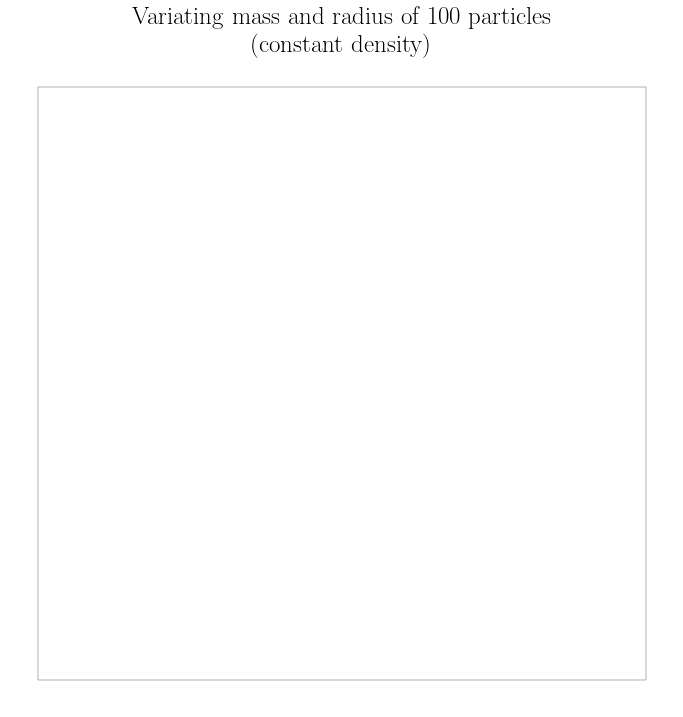

In [28]:
# Animating
positions, velocities, radia = load_data(my_simulation.nr_particles, my_simulation.nr_steps)
animate_box(positions, velocities, radia, my_simulation.box_width, save_animation=True)